In [1]:
import time
start_time = time.time()

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")[600000:]
len(candles)

loading NQ_1


250000

In [3]:
num_actions = 3

In [4]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

current_position = tf.keras.layers.Input(shape = (3,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(256)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(128)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(64)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(128)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(256)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(128)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(64)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(128)(m1_at)


#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, m1_at, m5_at])

d = tf.keras.layers.Dense(4096)(c)
d = lrelu(d)
d = tf.keras.layers.Dense(4096)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(2048)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(1024)(d)
d = lrelu(d)


value = tf.keras.layers.Dense(1, activation="linear")(d)
advantage = tf.keras.layers.Dense(num_actions, activation="linear")(d)

q_values = tf.keras.layers.Lambda(
lambda inputs: inputs[0] + (inputs[1] - tf.reduce_mean(inputs[1], axis=1, keepdims=True))
)([value, advantage])

outputs = tf.keras.layers.Activation('linear', dtype='float32')(q_values)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position], outputs = outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 94)       0           ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 60, 98)       0           ['input_3[0][0]',                
                                                                  'lambda[0][0]']             

In [5]:
model.load_weights("model.weights.h5")

In [6]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]


# In[11]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [7]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    tf.expand_dims(pos_info, 0)
                )

                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])[55:60]])

            if(last_action == 2 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  abs(entry-sl) * 1000


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  abs(entry-sl) * 1000

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [8]:
m = MultiTimeframeCandleManager()

slm = 1.5#1.5

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes,
        pos_info,
    ])



for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print(equity_L[-1])


  2%|█▎                                                                       | 4397/250000 [00:00<00:11, 21386.18it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.0
0.0
0.0
0.0
0.0


  2%|█▊                                                                         | 6110/250000 [00:20<18:43, 217.05it/s]

0.0


  2%|█▊                                                                         | 6119/250000 [00:20<18:49, 215.91it/s]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


  3%|██▏                                                                        | 7293/250000 [00:39<35:49, 112.93it/s]

0.0
0.0
0.0
0.0
0.0
0.0


  3%|██▍                                                                         | 7836/250000 [00:50<46:44, 86.35it/s]

0.0
-7.174999999999272
-0.6749999999992724
-11.700000000000728


  3%|██▌                                                                         | 8291/250000 [00:58<55:18, 72.85it/s]

-16.25
-16.25
-17.5


  3%|██▌                                                                         | 8593/250000 [01:03<58:20, 68.96it/s]

-17.5
-17.5


  4%|██▌                                                                       | 8799/250000 [01:07<1:01:11, 65.70it/s]

-17.5
-17.5


  4%|██▋                                                                       | 8941/250000 [01:09<1:00:42, 66.17it/s]

-17.5


  4%|██▊                                                                         | 9113/250000 [01:11<57:50, 69.41it/s]

-35.80000000000291


  4%|██▋                                                                       | 9203/250000 [01:13<1:01:30, 65.25it/s]

-51.37500000000364


  4%|██▊                                                                       | 9310/250000 [01:15<1:12:27, 55.37it/s]

-110.20000000000437


  4%|██▊                                                                       | 9408/250000 [01:17<1:20:45, 49.65it/s]

-94.95000000000437


  4%|██▊                                                                       | 9507/250000 [01:19<1:22:20, 48.67it/s]

-94.95000000000437


  4%|██▊                                                                       | 9610/250000 [01:21<1:10:27, 56.87it/s]

-94.95000000000437


  4%|██▉                                                                         | 9708/250000 [01:23<52:57, 75.63it/s]

-94.95000000000437


  4%|██▉                                                                         | 9813/250000 [01:24<49:58, 80.10it/s]

-94.95000000000437


  4%|██▉                                                                       | 9909/250000 [01:25<1:02:38, 63.89it/s]

-94.95000000000437


  4%|██▉                                                                      | 10011/250000 [01:27<1:07:19, 59.41it/s]

-94.95000000000437


  4%|██▉                                                                      | 10112/250000 [01:29<1:06:46, 59.88it/s]

-105.65000000000146


  4%|███                                                                        | 10210/250000 [01:30<50:30, 79.13it/s]

-118.5


  4%|███                                                                      | 10306/250000 [01:32<1:17:57, 51.24it/s]

-108.72499999999854


  4%|███                                                                      | 10406/250000 [01:34<1:26:02, 46.41it/s]

-104.54999999999927


  4%|███                                                                      | 10507/250000 [01:37<1:46:33, 37.46it/s]

-107.17499999999927


  4%|███                                                                      | 10604/250000 [01:39<1:40:20, 39.76it/s]

-122.77499999999782


  4%|███▏                                                                     | 10707/250000 [01:41<1:15:44, 52.66it/s]

-126.77499999999782


  4%|███▏                                                                     | 10811/250000 [01:43<1:10:31, 56.52it/s]

-99.77499999999782


  4%|███▎                                                                       | 10909/250000 [01:45<57:33, 69.23it/s]

-99.77499999999782


  4%|███▎                                                                       | 11009/250000 [01:46<57:42, 69.02it/s]

-99.77499999999782


  4%|███▏                                                                     | 11109/250000 [01:48<1:10:26, 56.52it/s]

-105.29999999999927


  4%|███▎                                                                     | 11211/250000 [01:50<1:13:01, 54.50it/s]

-105.29999999999927


  5%|███▎                                                                     | 11310/250000 [01:52<1:03:15, 62.89it/s]

-105.29999999999927


  5%|███▍                                                                       | 11416/250000 [01:53<47:35, 83.56it/s]

-105.29999999999927


  5%|███▎                                                                     | 11510/250000 [01:54<1:12:50, 54.57it/s]

-107.27499999999782


  5%|███▍                                                                     | 11606/250000 [01:56<1:19:30, 49.98it/s]

-104.52499999999782


  5%|███▍                                                                     | 11705/250000 [01:59<1:36:43, 41.06it/s]

-109.49999999999636


  5%|███▍                                                                     | 11805/250000 [02:01<1:34:03, 42.21it/s]

-118.2249999999949


  5%|███▍                                                                     | 11910/250000 [02:03<1:13:05, 54.29it/s]

-102.4749999999949


  5%|███▌                                                                     | 12008/250000 [02:05<1:11:52, 55.18it/s]

-111.2249999999949


  5%|███▌                                                                     | 12110/250000 [02:07<1:15:25, 52.57it/s]

-156.64999999999782


  5%|███▌                                                                     | 12207/250000 [02:09<1:12:20, 54.79it/s]

-122.14999999999782


  5%|███▌                                                                     | 12310/250000 [02:11<1:14:05, 53.47it/s]

-171.0


  5%|███▋                                                                       | 12413/250000 [02:12<52:53, 74.87it/s]

-174.0500000000029


  5%|███▊                                                                       | 12510/250000 [02:14<52:06, 75.97it/s]

-174.5500000000029


  5%|███▋                                                                     | 12608/250000 [02:15<1:04:04, 61.75it/s]

-177.45000000000437


  5%|███▋                                                                     | 12709/250000 [02:17<1:13:14, 53.99it/s]

-177.45000000000437


  5%|███▋                                                                     | 12811/250000 [02:19<1:12:52, 54.25it/s]

-179.20000000000437


  5%|███▊                                                                     | 12907/250000 [02:20<1:12:58, 54.15it/s]

-179.20000000000437


  5%|███▉                                                                       | 13011/250000 [02:22<57:38, 68.53it/s]

-179.20000000000437


  5%|███▊                                                                     | 13114/250000 [02:24<1:02:32, 63.13it/s]

-179.20000000000437


  5%|███▊                                                                     | 13206/250000 [02:26<1:42:06, 38.65it/s]

-179.20000000000437


  5%|███▉                                                                     | 13305/250000 [02:28<1:18:50, 50.03it/s]

-179.20000000000437


  5%|███▉                                                                     | 13407/250000 [02:30<1:19:18, 49.72it/s]

-144.45000000000437


  5%|███▉                                                                     | 13505/250000 [02:32<1:17:57, 50.56it/s]

-119.2750000000051


  5%|███▉                                                                     | 13608/250000 [02:34<1:11:06, 55.40it/s]

-83.0250000000051


  5%|████                                                                     | 13706/250000 [02:36<1:14:48, 52.65it/s]

-83.0250000000051


  6%|████                                                                     | 13808/250000 [02:38<1:17:44, 50.64it/s]

-122.9000000000051


  6%|████                                                                     | 13907/250000 [02:40<1:20:35, 48.83it/s]

-125.30000000000655


  6%|████                                                                     | 14010/250000 [02:42<1:10:13, 56.01it/s]

-119.80000000000655


  6%|████▏                                                                      | 14106/250000 [02:43<59:06, 66.52it/s]

-119.80000000000655


  6%|████▎                                                                      | 14207/250000 [02:45<59:34, 65.96it/s]

-119.80000000000655


  6%|████▏                                                                    | 14305/250000 [02:46<1:11:47, 54.71it/s]

-119.80000000000655


  6%|████▏                                                                    | 14407/250000 [02:48<1:14:28, 52.72it/s]

-119.80000000000655


  6%|████▏                                                                    | 14509/250000 [02:50<1:14:35, 52.62it/s]

-119.80000000000655


  6%|████▎                                                                    | 14605/250000 [02:52<1:12:48, 53.88it/s]

-119.80000000000655


  6%|████▎                                                                    | 14707/250000 [02:54<1:10:16, 55.80it/s]

-119.80000000000655


  6%|████▎                                                                    | 14809/250000 [02:56<1:13:23, 53.41it/s]

-119.80000000000655


  6%|████▎                                                                    | 14905/250000 [02:58<1:16:38, 51.13it/s]

-119.80000000000655


  6%|████▍                                                                    | 15007/250000 [03:00<1:17:57, 50.24it/s]

-119.80000000000655


  6%|████▍                                                                    | 15109/250000 [03:02<1:14:41, 52.41it/s]

-119.80000000000655


  6%|████▍                                                                    | 15205/250000 [03:04<1:14:23, 52.60it/s]

-119.80000000000655


  6%|████▍                                                                    | 15307/250000 [03:06<1:13:06, 53.51it/s]

-119.80000000000655


  6%|████▍                                                                    | 15408/250000 [03:08<1:15:50, 51.55it/s]

-119.80000000000655


  6%|████▌                                                                    | 15508/250000 [03:10<1:18:57, 49.50it/s]

-119.80000000000655


  6%|████▌                                                                    | 15608/250000 [03:12<1:19:53, 48.90it/s]

-119.80000000000655


  6%|████▌                                                                    | 15709/250000 [03:13<1:12:12, 54.07it/s]

-119.80000000000655


  6%|████▌                                                                    | 15811/250000 [03:15<1:12:14, 54.03it/s]

-119.80000000000655


  6%|████▋                                                                    | 15907/250000 [03:17<1:13:28, 53.10it/s]

-119.80000000000655


  6%|████▋                                                                    | 16008/250000 [03:19<1:14:05, 52.63it/s]

-119.80000000000655


  6%|████▋                                                                    | 16107/250000 [03:21<1:17:26, 50.34it/s]

-119.80000000000655


  6%|████▋                                                                    | 16209/250000 [03:23<1:10:39, 55.14it/s]

-119.80000000000655


  7%|████▊                                                                    | 16310/250000 [03:25<1:05:17, 59.65it/s]

-119.80000000000655


  7%|████▉                                                                      | 16413/250000 [03:26<52:39, 73.93it/s]

-119.80000000000655


  7%|████▊                                                                    | 16507/250000 [03:28<1:01:27, 63.31it/s]

-119.80000000000655


  7%|████▉                                                                      | 16615/250000 [03:29<50:37, 76.83it/s]

-119.80000000000655


  7%|████▉                                                                    | 16710/250000 [03:31<1:11:32, 54.35it/s]

-108.30000000000655


  7%|█████                                                                      | 16810/250000 [03:33<56:35, 68.67it/s]

-113.5250000000051


  7%|█████                                                                      | 16913/250000 [03:34<48:49, 79.56it/s]

-117.45000000000437


  7%|████▉                                                                    | 17011/250000 [03:36<1:09:33, 55.83it/s]

-113.12500000000364


  7%|████▉                                                                    | 17105/250000 [03:37<1:21:10, 47.82it/s]

-122.72500000000218


  7%|█████                                                                    | 17207/250000 [03:39<1:19:55, 48.55it/s]

-126.42500000000291


  7%|█████                                                                    | 17307/250000 [03:41<1:09:17, 55.97it/s]

-126.42500000000291


  7%|█████                                                                    | 17408/250000 [03:43<1:13:16, 52.91it/s]

-122.67500000000291


  7%|█████                                                                    | 17508/250000 [03:45<1:23:58, 46.15it/s]

-122.67500000000291


  7%|█████▏                                                                   | 17608/250000 [03:47<1:09:49, 55.47it/s]

-146.85000000000218


  7%|█████▎                                                                     | 17709/250000 [03:49<53:19, 72.60it/s]

-172.90000000000146


  7%|█████▏                                                                   | 17805/250000 [03:51<1:17:35, 49.87it/s]

-169.42499999999927


  7%|█████▎                                                                     | 17913/250000 [03:52<49:44, 77.77it/s]

-172.89999999999782


  7%|█████▎                                                                   | 18008/250000 [03:54<1:09:34, 55.57it/s]

-176.8249999999971


  7%|█████▎                                                                   | 18109/250000 [03:56<1:27:41, 44.07it/s]

-179.9499999999971


  7%|█████▎                                                                   | 18206/250000 [03:59<1:38:01, 39.41it/s]

-179.9499999999971


  7%|█████▎                                                                   | 18312/250000 [04:01<1:07:37, 57.10it/s]

-181.9499999999971


  7%|█████▎                                                                   | 18407/250000 [04:02<1:07:07, 57.51it/s]

-181.9499999999971


  7%|█████▍                                                                   | 18506/250000 [04:04<1:07:57, 56.78it/s]

-181.9499999999971


  7%|█████▍                                                                   | 18610/250000 [04:06<1:05:15, 59.10it/s]

-181.9499999999971


  7%|█████▍                                                                   | 18709/250000 [04:08<1:02:25, 61.75it/s]

-181.9499999999971


  8%|█████▋                                                                     | 18811/250000 [04:09<49:51, 77.29it/s]

-181.9499999999971


  8%|█████▌                                                                   | 18911/250000 [04:11<1:02:19, 61.79it/s]

-181.9499999999971


  8%|█████▌                                                                   | 19006/250000 [04:12<1:07:06, 57.36it/s]

-181.9499999999971


  8%|█████▋                                                                     | 19110/250000 [04:14<59:07, 65.09it/s]

-181.9499999999971


  8%|█████▊                                                                     | 19212/250000 [04:15<53:40, 71.67it/s]

-181.9499999999971


  8%|█████▋                                                                   | 19310/250000 [04:17<1:03:48, 60.26it/s]

-186.174999999992


  8%|█████▋                                                                   | 19409/250000 [04:19<1:08:17, 56.28it/s]

-183.37499999999272


  8%|█████▋                                                                   | 19510/250000 [04:21<1:07:32, 56.87it/s]

-192.57499999999345


  8%|█████▉                                                                     | 19613/250000 [04:22<57:08, 67.21it/s]

-198.174999999992


  8%|█████▊                                                                   | 19706/250000 [04:24<1:00:52, 63.04it/s]

-191.674999999992


  8%|█████▊                                                                   | 19803/250000 [04:26<1:32:19, 41.56it/s]

-191.674999999992


  8%|█████▊                                                                   | 19908/250000 [04:28<1:21:01, 47.33it/s]

-191.674999999992


  8%|█████▊                                                                   | 20008/250000 [04:30<1:22:29, 46.47it/s]

-191.674999999992


  8%|█████▊                                                                   | 20110/250000 [04:32<1:14:38, 51.34it/s]

-191.674999999992


  8%|█████▉                                                                   | 20210/250000 [04:34<1:00:46, 63.01it/s]

-191.674999999992


  8%|██████                                                                     | 20307/250000 [04:35<57:04, 67.07it/s]

-191.674999999992


  8%|█████▉                                                                   | 20407/250000 [04:37<1:18:17, 48.87it/s]

-140.424999999992


  8%|█████▉                                                                   | 20508/250000 [04:39<1:01:48, 61.89it/s]

-143.174999999992


  8%|██████▏                                                                    | 20606/250000 [04:40<58:29, 65.36it/s]

-143.174999999992


  8%|██████                                                                   | 20707/250000 [04:42<1:11:25, 53.50it/s]

-143.174999999992


  8%|██████                                                                   | 20809/250000 [04:44<1:12:13, 52.89it/s]

-131.924999999992


  8%|██████                                                                   | 20911/250000 [04:46<1:12:31, 52.65it/s]

-73.174999999992


  8%|██████▎                                                                    | 21009/250000 [04:47<55:48, 68.38it/s]

-61.174999999991996


  8%|██████▏                                                                  | 21105/250000 [04:49<1:08:36, 55.60it/s]

-57.674999999991996


  8%|██████▏                                                                  | 21209/250000 [04:51<1:18:19, 48.68it/s]

-77.27499999999418


  9%|██████▏                                                                  | 21305/250000 [04:53<1:18:26, 48.59it/s]

-77.27499999999418


  9%|██████▎                                                                  | 21408/250000 [04:55<1:20:58, 47.05it/s]

-76.52499999999418


  9%|██████▎                                                                  | 21511/250000 [04:57<1:07:14, 56.63it/s]

-106.69999999999345


  9%|██████▍                                                                    | 21607/250000 [04:59<50:43, 75.04it/s]

-106.69999999999345


  9%|██████▎                                                                  | 21710/250000 [05:00<1:17:39, 49.00it/s]

-106.69999999999345


  9%|██████▎                                                                  | 21808/250000 [05:03<1:18:28, 48.47it/s]

-102.94999999999345


  9%|██████▍                                                                  | 21909/250000 [05:05<1:19:48, 47.63it/s]

-97.19999999999345


  9%|██████▍                                                                  | 22007/250000 [05:07<1:17:26, 49.07it/s]

-97.19999999999345


  9%|██████▍                                                                  | 22109/250000 [05:09<1:18:16, 48.52it/s]

-97.19999999999345


  9%|██████▍                                                                  | 22209/250000 [05:11<1:18:34, 48.32it/s]

-97.19999999999345


  9%|██████▌                                                                  | 22307/250000 [05:13<1:17:13, 49.14it/s]

-97.19999999999345


  9%|██████▌                                                                  | 22410/250000 [05:15<1:17:27, 48.97it/s]

-122.89999999999054


  9%|██████▌                                                                  | 22504/250000 [05:17<1:15:37, 50.14it/s]

-153.0749999999898


  9%|██████▌                                                                  | 22608/250000 [05:19<1:16:41, 49.42it/s]

-153.0749999999898


  9%|██████▋                                                                  | 22707/250000 [05:21<1:20:49, 46.87it/s]

-153.0749999999898


  9%|██████▋                                                                  | 22805/250000 [05:23<1:18:11, 48.43it/s]

-153.0749999999898


  9%|██████▋                                                                  | 22910/250000 [05:25<1:16:31, 49.46it/s]

-168.5749999999898


  9%|██████▋                                                                  | 23006/250000 [05:27<1:16:30, 49.45it/s]

-176.2499999999891


  9%|██████▋                                                                  | 23105/250000 [05:29<1:18:53, 47.93it/s]

-176.2499999999891


  9%|██████▊                                                                  | 23205/250000 [05:31<1:17:50, 48.56it/s]

-201.3249999999898


  9%|██████▊                                                                  | 23311/250000 [05:33<1:15:13, 50.22it/s]

-201.3249999999898


  9%|██████▊                                                                  | 23406/250000 [05:35<1:21:46, 46.18it/s]

-201.3249999999898


  9%|██████▊                                                                  | 23510/250000 [05:37<1:13:33, 51.32it/s]

-201.3249999999898


  9%|██████▉                                                                  | 23603/250000 [05:39<1:14:48, 50.43it/s]

-201.3249999999898


  9%|██████▉                                                                  | 23709/250000 [05:42<1:12:23, 52.10it/s]

-194.0749999999898


 10%|██████▉                                                                  | 23813/250000 [05:43<1:08:10, 55.30it/s]

-194.0749999999898


 10%|███████▏                                                                   | 23904/250000 [05:45<54:28, 69.17it/s]


-194.0749999999898


KeyboardInterrupt: 

0 -194.0749999999898


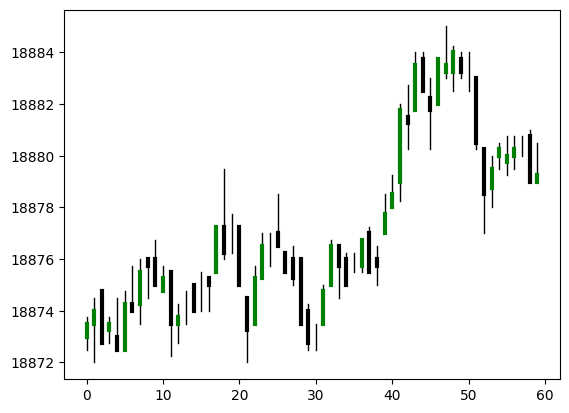

In [9]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

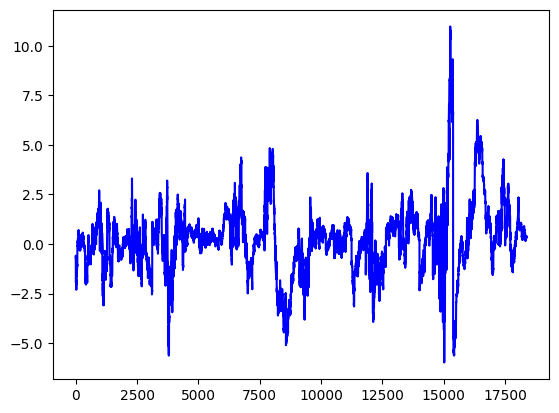

In [10]:
plt.plot([x[1]-x[0] for x in outputs], color="b")

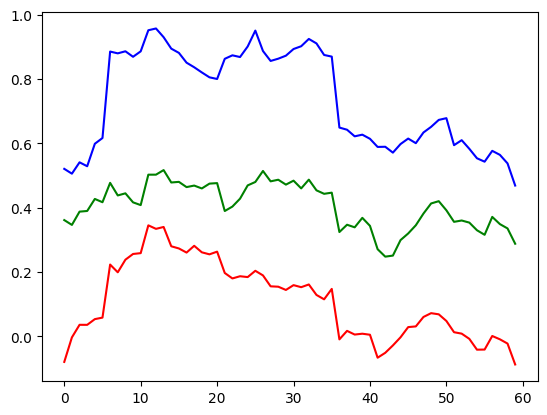

In [11]:
plt.plot([x[0] for x in outputs[-60:]], color="r")
plt.plot([x[1] for x in outputs[-60:]], color="g")
plt.plot([x[2] for x in outputs[-60:]], color="b")

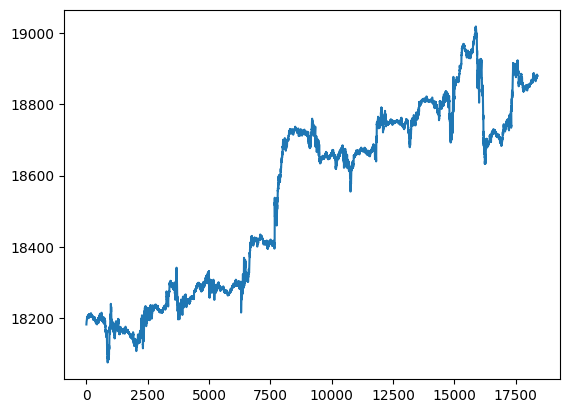

In [12]:
plt.plot([x.c for x in all_candles])

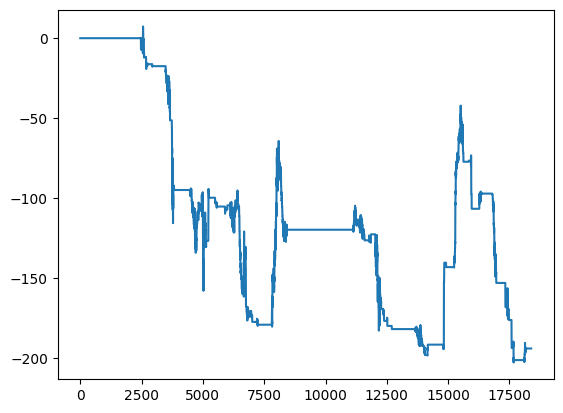

In [13]:
plt.plot(equity_L)

In [ ]:
#exit()